In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [13]:
kharpov = False

In [14]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -17,
                   'log_scale': -4.3,
                   'logit_rho': 3.36,
                   'phi': -0.3,
                    'pi': 0, 
                   'theta': 0.45}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 10_000
sim_dim = 1000
innov_dim = 250

In [15]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(logit_rho=true_params['logit_rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(logit_rho=true_params['logit_rho'], log_scale=true_params['log_scale'], 
                          phi=true_params['phi'], theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [16]:
def compute_moments(log_both, logit_rho, log_scale, phi, pi, theta):
    
    vol_mean = np.exp(log_both) / (1 - special.expit(logit_rho))
    vol_var = ((2 * np.exp(log_scale) * special.expit(logit_rho) * vol_mean + np.exp(log_scale)**2 
                * np.exp(log_both - log_scale)) / (1 - special.expit(logit_rho)**2))
    
    psi = vl.compute_psi(logit_rho=logit_rho, log_scale=log_scale, phi=phi, theta=theta)
    beta = vl.compute_beta(logit_rho=logit_rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(log_both=log_both, logit_rho=logit_rho, log_scale=log_scale, phi=phi, pi=pi,
                             theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [17]:
compute_moments(**true_params)

{'return_mean': -5.4485139820073995e-08,
 'return_var': 4.405439360478335e-06,
 'vol_mean': 1.2332539493306796e-06,
 'vol_var': 4.984767996629148e-07}

In [18]:
vl.compute_gamma(**true_params)

7.541927573173943e-08

In [19]:
total_true_params

{'log_both': -17,
 'log_scale': -4.3,
 'logit_rho': 3.36,
 'phi': -0.3,
 'pi': 0,
 'theta': 0.45,
 'gamma': 7.541927573173943e-08,
 'beta': 1.7612887920398665,
 'psi': -1.866623476451229,
 'zeta': 0.91}

In [20]:
true_params

{'log_both': -17,
 'log_scale': -4.3,
 'logit_rho': 3.36,
 'phi': -0.3,
 'pi': 0,
 'theta': 0.45}

In [21]:
total_true_params

{'log_both': -17,
 'log_scale': -4.3,
 'logit_rho': 3.36,
 'phi': -0.3,
 'pi': 0,
 'theta': 0.45,
 'gamma': 7.541927573173943e-08,
 'beta': 1.7612887920398665,
 'psi': -1.866623476451229,
 'zeta': 0.91}

In [26]:
vl.compute_link([0.45, -4, 0], true_params, case=1)

TypeError: _lambdifygenerated() got multiple values for argument 'phi'

## We start by examining the distributions of simulated data

In [27]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [28]:
data.corr()

,vol,rtn
vol,1.000000,-0.323991
rtn,-0.323991,1.000000


In [29]:
data.head()

,vol,rtn
2000-01-01,0.00001,0.004600
2000-01-02,0.00001,0.002853
2000-01-03,0.00001,-0.003825
2000-01-04,0.00001,0.001721
2000-01-05,0.00001,-0.001253


In [30]:
data.vol.var()

2.4344252647881655e-06

In [31]:
init_constants = vl.compute_init_constants(data.vol)

In [32]:
init_constants

{'log_both': -11.280150392625364,
 'log_scale': -4.713064950289146,
 'logit_rho': 0.7842735558272771}

In [33]:
vl.compute_vol_gmm(data.vol, init_constants)

({'log_both': -11.8640942671293,
  'log_scale': -4.868274607472477,
  'logit_rho': 1.5402430004929595},
            log_both  log_scale  logit_rho
 log_both   0.229498   0.042306   0.001225
 log_scale  0.042306   0.057679   0.077288
 logit_rho  0.001225   0.077288   0.970151)

In [34]:
omega, omega_cov = vl.estimate_params(data)

In [35]:
omega

{'gamma': -3.214285588175864e-06,
 'beta': 1.6739032658640591,
 'psi': -2.4073878200010754,
 'zeta': 0.9040487957973237,
 'log_both': -11.8640942671293,
 'log_scale': -4.868274607472477,
 'logit_rho': 1.5402430004929595}

In [36]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,9.350354e-03,-7.378929e-08,0.000000,0.000000,0.000000,-0.008089,0.00000
gamma,-7.378929e-08,1.093685e-09,0.000000,0.000000,0.000000,-0.000019,0.00000
log_both,0.000000e+00,0.000000e+00,0.229498,0.042306,0.001225,0.000000,0.00000
log_scale,0.000000e+00,0.000000e+00,0.042306,0.057679,0.077288,0.000000,0.00000
logit_rho,0.000000e+00,0.000000e+00,0.001225,0.077288,0.970151,0.000000,0.00000
psi,-8.089096e-03,-1.862022e-05,0.000000,0.000000,0.000000,1.872240,0.00000
zeta,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00016


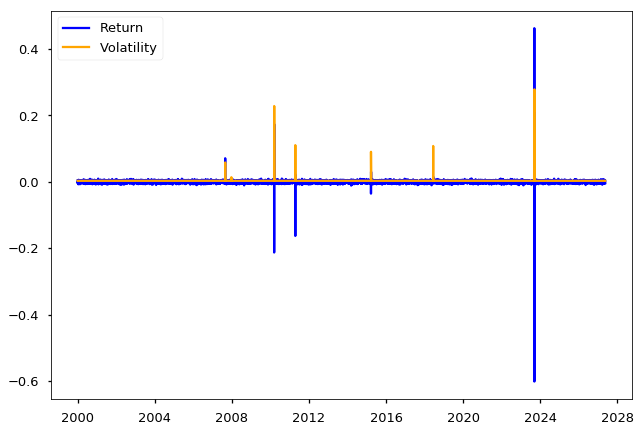

In [37]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [38]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.000047,-0.000016
rtn,-0.000016,0.000083


In [39]:
total_true_params

{'log_both': -17,
 'log_scale': -4.3,
 'logit_rho': 3.36,
 'phi': -0.3,
 'pi': 0,
 'theta': 0.45,
 'gamma': 7.541927573173943e-08,
 'beta': 1.7612887920398665,
 'psi': -1.866623476451229,
 'zeta': 0.91}

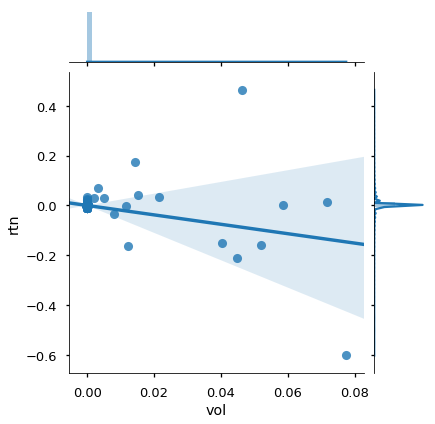

In [40]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [41]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,0.000058,-0.000046
std,0.001560,0.009105
min,0.000010,-0.601081
25%,0.000010,-0.002061
50%,0.000010,-0.000009
75%,0.000010,0.002056
max,0.077501,0.462601


## I now estimate all of the parameters

In [42]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [43]:
def vol_estimator(data):
    return vl.compute_vol_gmm(data.vol, init_constants=vl.compute_init_constants(data.vol))

In [44]:
true_params

{'log_both': -17,
 'log_scale': -4.3,
 'logit_rho': 3.36,
 'phi': -0.3,
 'pi': 0,
 'theta': 0.45}

In [45]:
vol_estimator(data_arr[2])

({'log_both': -11.195179084759987,
  'log_scale': -4.376180896463301,
  'logit_rho': 3.0847269183120236},
            log_both  log_scale  logit_rho
 log_both   0.572658   0.099038  -0.219301
 log_scale  0.099038   0.081046   0.166776
 logit_rho -0.219301   0.166776   4.802461)

In [46]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vol_estimator, data_arr),
                                      total=len(data_arr)))

In [47]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [ ]:
ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
            for est in est_arr]

In [ ]:
vol_fig, vol_ax = mpl.pyplot.subplots()
sns.distplot(ar_stats, ax=vol_ax)
vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
vol_ax.set_xlim([0,20])
vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [ ]:
100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

In [ ]:
t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
            for est in est_arr for name in ['logit_rho', 'log_scale', 'log_both']]
t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [ ]:
vl.compute_init_constants(data.vol)

In [ ]:
true_params['log_both']

In [ ]:
np.amin([est[0]['log_both'] for est in est_arr])

In [ ]:
t_stats_df.describe()

In [ ]:
for name, col in t_stats_df.items():
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

In [ ]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
#         if max(ax.get_xlim()) > 20:
#             ax.set_xlim(-20, 20)

In [ ]:
fig, ax = mpl.pyplot.subplots()       
sns.distplot(pd.Series([est['pi'] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
ax.axvline(total_true_params['pi'], color='black')
ax.set_xlabel('$\pi$')
fig.savefig('../doc/figures/pi_est_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
                        frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega


In [ ]:
true_params

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [ ]:
def compute_ar(params, case=1):
    param_est, param_cov = params
    names = vl.compute_names(case)
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov, case=case)

In [ ]:
param_est, param_cov = est_arr[0]
names = vl.compute_names(1)
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
# data.shape[0] * vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
vl.compute_link(prices=true_prices, omega=omega, case=1)

In [ ]:
compute_ar(est_arr[0])

In [ ]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
 stats.chi2.ppf(df=4, q=.95)

In [ ]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)